In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from time import time
from tqdm.notebook import tqdm
from typing import List, Union, Tuple

import wandb
import torch
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

from segmentation.model import SegmentationModel
from segmentation.train_utils import benchmark_inference_time

In [3]:
PROJECT="CamVid"
ENTITY="av-demo"
IMAGE_SHAPE = (720, 960)
SEED = 123
RUN_NAME = "baseline-train-1"
JOB_TYPE = "baseline-train"

ARTIFACT_ID = "av-demo/CamVid/camvid-dataset:v0"

BATCH_SIZE = 16
IMAGE_RESIZE_FACTOR = 4
VALIDATION_SPLIT = 0.2
HIDDEN_DIM = 256
BACKBONE = "mobilenetv2_100"

LEARNING_RATE = 1e-3
TRAIN_EPOCHS = 10

INFERENCE_BATCH_SIZE = 8
NUM_WARMUP_ITERS = 10
NUM_INFERENCE_BENCHMARK_ITERS = 50

In [4]:
set_seed(SEED)

In [5]:
run = wandb.init(
    project=PROJECT,
    name=RUN_NAME,
    entity=ENTITY,
    job_type=JOB_TYPE,
    config={
        "artifact_id": ARTIFACT_ID,
        "image_shape": IMAGE_SHAPE,
        "batch_size": BATCH_SIZE,
        "image_resize_factor": IMAGE_RESIZE_FACTOR,
        "validation_split": VALIDATION_SPLIT,
        "hidden_dims": HIDDEN_DIM,
        "backbone": BACKBONE,
        "learning_rate": LEARNING_RATE,
        "train_epochs": TRAIN_EPOCHS,
        "inference_batch_size": INFERENCE_BATCH_SIZE,
        "num_warmup_iters": NUM_WARMUP_ITERS,
        "num_inference_banchmark_iters": NUM_INFERENCE_BENCHMARK_ITERS
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: av-demo (use `wandb login --relogin` to force relogin)


## DataLoader for SegmentationDataLoader for Segmentation

In [6]:
def label_func(fn):
    return fn.parent.parent/"labels"/f"{fn.stem}_P{fn.suffix}"


def get_dataloader(
    artifact_id: str,
    batch_size: int,
    image_shape: Tuple[int, int],
    resize_factor: int,
    validation_split: float,
    seed: int
):
    """Grab an artifact and creating a Pytorch DataLoader"""
    artifact = wandb.use_artifact(artifact_id, type='dataset')
    artifact_dir = Path(artifact.download())
    codes = np.loadtxt(artifact_dir/'codes.txt', dtype=str)
    fnames = get_image_files(artifact_dir/"images")
    class_labels = {k: v for k, v in enumerate(codes)}
    return SegmentationDataLoaders.from_label_func(
        artifact_dir,
        bs=batch_size,
        fnames=fnames,
        label_func=label_func,
        codes=codes,
        item_tfms=Resize((
            image_shape[0] // resize_factor,
            image_shape[1] // resize_factor
        )),
        valid_pct=validation_split,
        seed=seed
    ), class_labels

wandb: Downloading large artifact camvid-dataset:v0, 1456.69MB. 1422 files... Done. 0:0:0


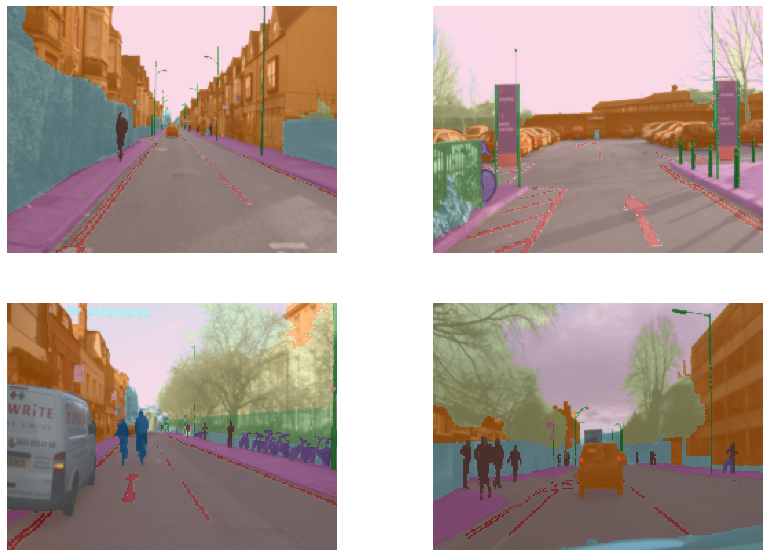

In [7]:
data_loader, class_labels = get_dataloader(
    artifact_id=ARTIFACT_ID,
    batch_size=BATCH_SIZE,
    image_shape=IMAGE_SHAPE,
    resize_factor=IMAGE_RESIZE_FACTOR,
    validation_split=VALIDATION_SPLIT,
    seed=SEED
)

data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Training and Inference

In [8]:
def get_model_parameters(model):
    with torch.no_grad():
        num_params = sum(p.numel() for p in model.parameters())
    return num_params


def get_predictions(learner):
    inputs, predictions, targets, outputs = learner.get_preds(with_input=True, with_decoded=True)
    x, y, samples, outputs = learner.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=36
    )
    return samples, outputs, predictions


def create_wandb_table(samples, outputs, class_labels):
    "Creates a wandb table with predictions and targets side by side"
    table = wandb.Table(columns=["Image", "Predicted Mask", "Ground Truth"])
    for (image, label), pred_label in zip(samples, outputs):
        image = image.permute(1, 2, 0)
        table.add_data(
            wandb.Image(image),
            wandb.Image(
                image,
                masks={
                    "predictions":  {
                        'mask_data':  pred_label[0].numpy(),
                        'class_labels':class_labels
                    }
                }
            ),
            wandb.Image(
                image,
                masks={
                    "ground truths": {
                        'mask_data': label.numpy(),
                        'class_labels':class_labels
                    }
                }
            )
        )
    return table

In [9]:
def get_learner(
    data_loader,
    backbone: str,
    hidden_dim: int,
    num_classes: int,
    checkpoint_file: Union[None, str, Path],
    loss_func,
    metrics: List,
    log_preds: bool = False
):
    model = SegmentationModel(backbone, hidden_dim, num_classes=num_classes)
    save_model_callback = SaveModelCallback(fname=f"unet_{backbone}")
    mixed_precision_callback = MixedPrecision()
    wandb_callback = WandbCallback(log_preds=log_preds)
    learner = Learner(
        data_loader,
        model,
        loss_func=loss_func,
        metrics=metrics,
        cbs=[save_model_callback, mixed_precision_callback, wandb_callback],
    )
    if checkpoint_file is not None:
        learner.load(checkpoint_file)
    return learner

In [10]:
learner = get_learner(
    data_loader,
    backbone=BACKBONE,
    hidden_dim=HIDDEN_DIM,
    num_classes=len(class_labels),
    checkpoint_file=None,
    loss_func=FocalLossFlat(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    log_preds=True
)

In [11]:
# learner.fine_tune(10, 1e-3)
learner.fit_one_cycle(TRAIN_EPOCHS, LEARNING_RATE)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,2.002725,1.037719,0.106407,0.705033,00:15
1,1.111527,0.512123,0.215986,0.812036,00:09
2,0.704952,0.448450,0.277952,0.821452,00:09
3,0.489088,0.439410,0.345351,0.812334,00:10
4,0.364114,0.346934,0.339886,0.825513,00:10
5,0.283090,0.269501,0.409224,0.864684,00:10
6,0.230797,0.238261,0.449584,0.875703,00:10
7,0.196650,0.232273,0.460698,0.877371,00:10
8,0.173863,0.221851,0.465658,0.880361,00:10
9,0.160840,0.218426,0.468819,0.882556,00:09


Better model found at epoch 0 with valid_loss value: 1.0377191305160522.
Better model found at epoch 1 with valid_loss value: 0.5121228098869324.
Better model found at epoch 2 with valid_loss value: 0.44844964146614075.
Better model found at epoch 3 with valid_loss value: 0.4394095838069916.
Better model found at epoch 4 with valid_loss value: 0.3469335436820984.
Better model found at epoch 5 with valid_loss value: 0.26950058341026306.
Better model found at epoch 6 with valid_loss value: 0.23826099932193756.
Better model found at epoch 7 with valid_loss value: 0.23227348923683167.
Better model found at epoch 8 with valid_loss value: 0.22185102105140686.
Better model found at epoch 9 with valid_loss value: 0.21842578053474426.


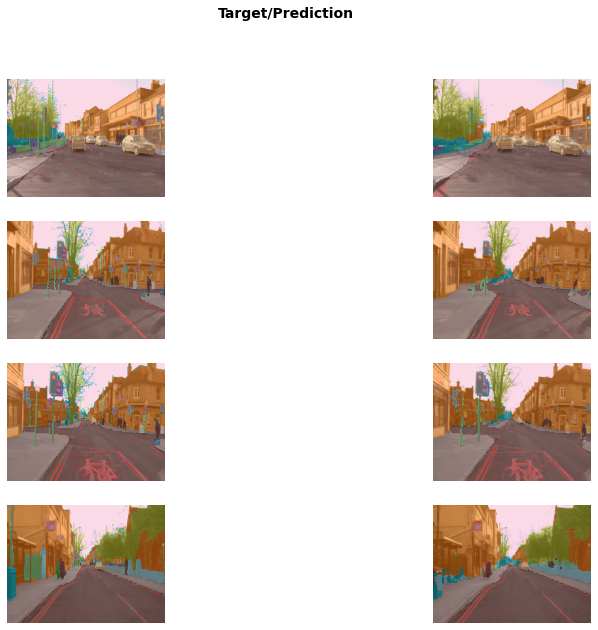

In [12]:
learner.show_results(max_n=4, figsize=(14, 10))

In [13]:
samples, outputs, _ = get_predictions(learner)
table = create_wandb_table(samples, outputs, class_labels)
wandb.log({f"Baseline_Predictions_{run.name}": table})

In [14]:
model = learner.model.eval()
torch.cuda.empty_cache()
wandb.log({"Model_Parameters": get_model_parameters(model)})
wandb.log({
    "Inference_Time": benchmark_inference_time(
        model=model,
        batch_size=INFERENCE_BATCH_SIZE,
        image_shape=IMAGE_SHAPE,
        num_warmup_iters=NUM_WARMUP_ITERS,
        num_iter=NUM_INFERENCE_BENCHMARK_ITERS,
        seed=SEED
    )
})

wandb: Downloading large artifact camvid-dataset:v0, 1456.69MB. 1422 files... Done. 0:0:0


Warming up GPU...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.05it/s]


Computing inference time over 50 iterations with batches of 8 images...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.10s/it]


In [15]:
run.finish()

Inference_Time,▁
Model_Parameters,▁
dice_multi,▁▃▄▆▆▇████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,▁▅▆▅▆▇████
lr_0,▁▂▂▃▄▅▆▇▇██████▇▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▆▆▄▃▂▂▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,█▇▅▄▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
